# Library Load

In [44]:
from map_boxes import mean_average_precision_for_boxes
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor
import random

In [45]:
GT_JSON = '../dataset/train.json'
# load ground truth
with open(GT_JSON, 'r') as outfile:
    json_file = (json.load(outfile))

In [46]:
images = pd.DataFrame(json_file["images"])
annotations = pd.DataFrame(json_file["annotations"])

print("--------------images-------------------")
print(images.head(5))
print()

print("--------------annotations-------------------")
print(annotations.head(5))

--------------images-------------------
   width  height       file_name  license flickr_url coco_url  \
0   1024    1024  train/0000.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   
2   1024    1024  train/0002.jpg        0       None     None   
3   1024    1024  train/0003.jpg        0       None     None   
4   1024    1024  train/0004.jpg        0       None     None   

         date_captured  id  
0  2020-12-26 14:44:23   0  
1  2021-01-10 16:30:39   1  
2  2020-12-27 17:55:52   2  
3  2021-03-31 12:10:36   3  
4  2021-01-01 18:52:38   4  

--------------annotations-------------------
   image_id  category_id       area                          bbox  iscrowd  id
0         0            0  257301.66  [197.6, 193.7, 547.8, 469.7]        0   0
1         1            3   10402.56     [0.0, 407.4, 57.6, 180.6]        0   1
2         1            7   26259.36    [0.0, 455.6, 144.6, 181.6]        0   2
3         1            4   69096.

# 결측치 확인 및 drop

In [149]:
print('image', len(images))
print('annotation', len(annotations))
annotations.head()

image 4883
annotation 23144


image_id  category_id       area                          bbox  id  ann_cnt
0         0            0  257301.66  [197.6, 193.7, 547.8, 469.7]   0        1
1         1            3   10402.56     [0.0, 407.4, 57.6, 180.6]   1        8
2         1            7   26259.36    [0.0, 455.6, 144.6, 181.6]   2        8
3         1            4   69096.17  [722.3, 313.4, 274.3, 251.9]   3        8
4         1            5   24164.58  [353.2, 671.0, 233.7, 103.4]   4        8

In [48]:
annotations['iscrowd'].unique()

array([0])

In [49]:
annotations = annotations.drop(columns='iscrowd')

# Label Distribution

In [50]:
label_list = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

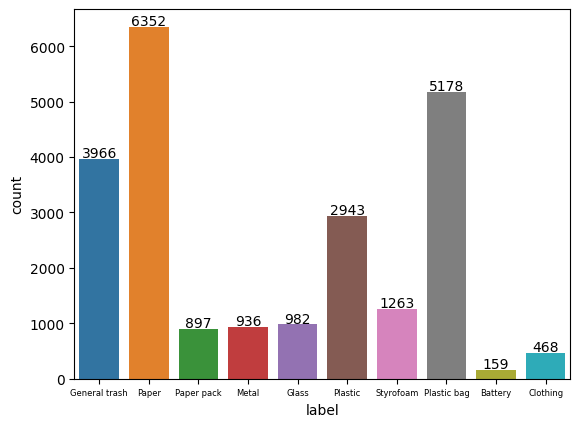

In [51]:
ax = sns.countplot(x = 'category_id', data=annotations)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, int(height), ha = 'center', size = 10)

plt.xlabel('label')
ax.set_xticklabels(label_list,size=6)
plt.show()

라벨 불균형 심각  
8, 9번 라벨 수가 특히 적음

# Features

## BBox

In [52]:
# bounding box 그리기
def drawBoundingBox(img_id):
    img_path = f"../dataset/train/{str(img_id).zfill(4)}.jpg"
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    colors = ["Red", "Orange", "Green", "Yellow", "Brown", "Blue", "Pink", "Turquoise", "Violet", "White"] 
    anns = annotations[annotations["image_id"] == img_id]
    for _, ann in anns.iterrows():
        box = ann.bbox
        category = ann.category_id
        draw.rectangle((box[0], box[1], box[0] + box[2], box[1] + box[3]), outline = ImageColor.getrgb(colors[category]), width=3)
    return img

image 당 annotaion 평균 :  4.739709195166905
annotation max :  71
annotation min :  1


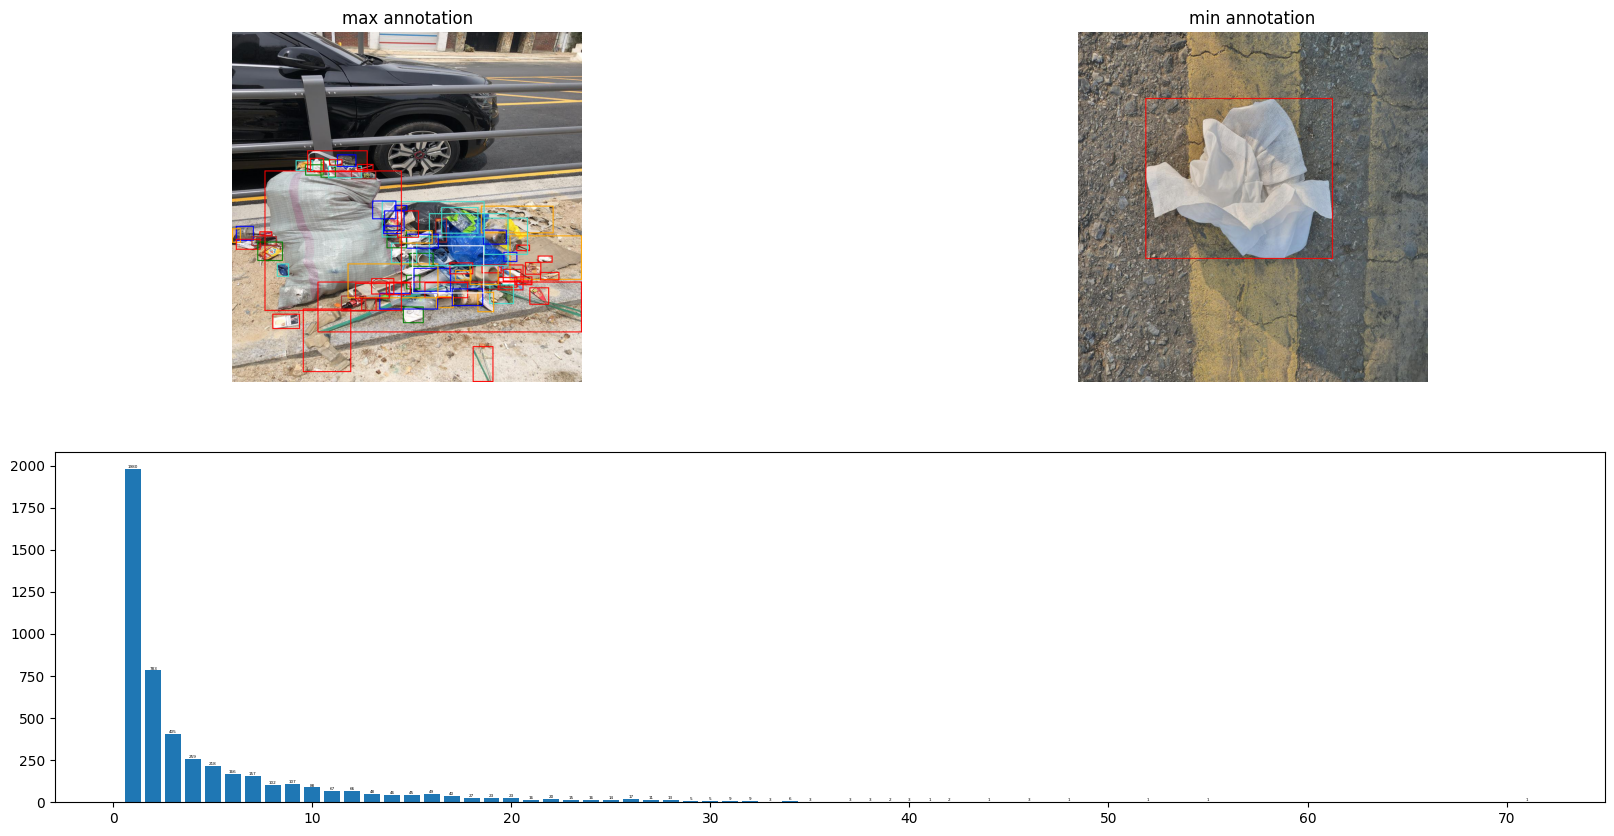

In [53]:
# 이미지 별 annotation 개수
print("image 당 annotaion 평균 : ", len(annotations)/len(images))

annotation_per_image = annotations["image_id"].value_counts().sort_index()

plt.figure(figsize=(20,10))

# 최대값
max_ann_idx = annotation_per_image.idxmax()
max_ann = annotation_per_image.max()
print("annotation max : ", max_ann)
plt.subplot(2,2,1)
plt.title("max annotation")
plt.axis("off")
plt.imshow(drawBoundingBox(max_ann_idx))

# 최소값
min_ann_idx = annotation_per_image.idxmin()
min_ann = annotation_per_image.min()
print("annotation min : ", min_ann)
plt.subplot(2,2,2)
plt.title("min annotation")
plt.axis("off")
plt.imshow(drawBoundingBox(min_ann_idx))

# annotation 개수 분포
plt.subplot(2,1,2)
annotation_distribution = annotation_per_image.value_counts()
bar = plt.bar(annotation_distribution.index, annotation_distribution.values)
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, height, ha = "center", va = "bottom", size = 3)


plt.show()

# Area

## ann_cnt

<annotation size>
max :  1048371.21
min :  0.56


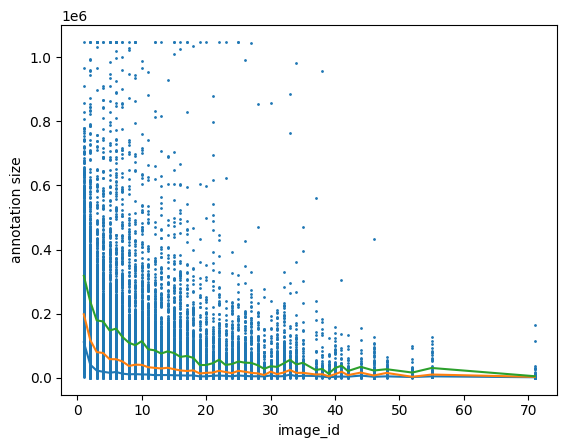

In [80]:
# annotation 크기 (개수와 크기 관계)

ann_size = []
ann_cnt = []
annotaion_per_image = annotations["image_id"].value_counts().sort_index()


for idx, ann in annotations.iterrows():
    ann_size.append(ann["area"])
    ann_cnt.append(annotaion_per_image[int(ann["image_id"])])

annotations['ann_cnt'] = ann_cnt
x_1 = annotations.groupby('ann_cnt')['area'].quantile(0.25).index
y_1 = annotations.groupby('ann_cnt')['area'].quantile(0.25).values

x_2 = annotations.groupby('ann_cnt')['area'].quantile(0.5).index
y_2 = annotations.groupby('ann_cnt')['area'].quantile(0.5).values

x_3 = annotations.groupby('ann_cnt')['area'].quantile(0.75).index
y_3 = annotations.groupby('ann_cnt')['area'].quantile(0.75).values

print("<annotation size>")
print("max : ", max(ann_size))
print("min : ", min(ann_size))

plt.scatter(ann_cnt, ann_size, s=1)
plt.plot(x_1, y_1)
plt.plot(x_2, y_2)
plt.plot(x_3, y_3)
plt.xlabel("image_id")
plt.ylabel("annotation size")
plt.show()

green(Q3), orange(Q2), blue(Q1)  
annotation 개수 별로 area에 차이가 있는 것을 확인할 수 있음!

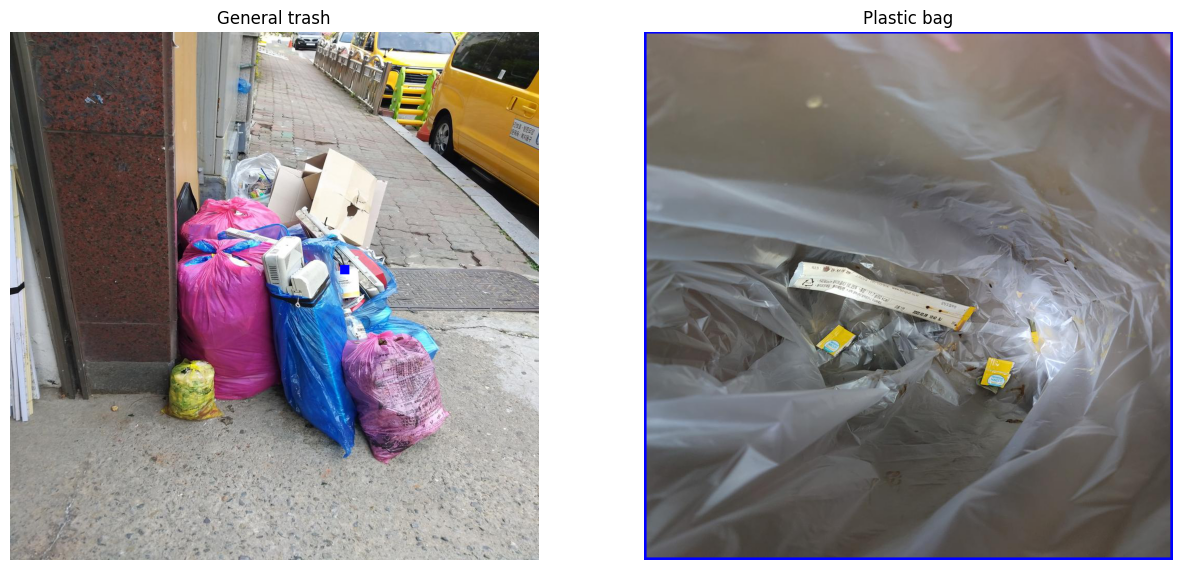

In [125]:
min_idx = annotations['area'].idxmin()
min_id = annotations.loc[annotations['area'].idxmin(), 'image_id']
img_path = f"../dataset/train/{str(min_id).zfill(4)}.jpg"
img = Image.open(img_path)
draw = ImageDraw.Draw(img)
box = annotations.loc[annotations['area'].idxmin(), 'bbox']
draw.rectangle((box[0], box[1], box[0] + box[2], box[1] + box[3]), outline = 'Blue', width=10)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title(label_list[annotations.loc[min_idx, 'category_id']])
plt.axis("off")
plt.imshow(img)

max_idx = annotations['area'].idxmax()
max_id = annotations.loc[annotations['area'].idxmax(), 'image_id']
img_path = f"../dataset/train/{str(max_id).zfill(4)}.jpg"
img = Image.open(img_path)
draw = ImageDraw.Draw(img)
box = annotations.loc[annotations['area'].idxmax(), 'bbox']
draw.rectangle((box[0], box[1], box[0] + box[2], box[1] + box[3]), outline = 'Blue', width=5)

plt.subplot(1, 2, 2)
plt.title(label_list[annotations.loc[max_idx, 'category_id']])
plt.axis("off")
plt.imshow(img)

- 이미지 전체에 bounding box가 표기된 경우도 있음
- annotation이 지나치게 많은 경우에는 사람 육안으로도 구별하기 어려운 경우가 많다.  
-> 모델에 혼란을 줄 수도 있으므로 annotation이 많은 데이터는 삭제하는 방법  
-> area가 일정 크기 이하로 작은 경우는 삭제하는 방법

## label 별

<annotation size>
max :  1048371.21
min :  0.56


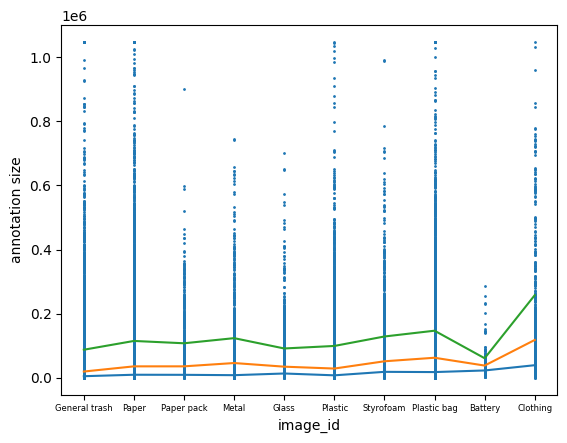

In [150]:
x_1 = annotations.groupby('category_id')['area'].quantile(0.25).index
y_1 = annotations.groupby('category_id')['area'].quantile(0.25).values

x_2 = annotations.groupby('category_id')['area'].quantile(0.5).index
y_2 = annotations.groupby('category_id')['area'].quantile(0.5).values

x_3 = annotations.groupby('category_id')['area'].quantile(0.75).index
y_3 = annotations.groupby('category_id')['area'].quantile(0.75).values

print("<annotation size>")
print("max : ", max(ann_size))
print("min : ", min(ann_size))

plt.scatter(annotations['category_id'], annotations['area'], s=1)
plt.plot(x_1, y_1)
plt.plot(x_2, y_2)
plt.plot(x_3, y_3)
plt.xlabel("image_id")
plt.xticks(np.arange(0,10), label_list, size=6)
plt.ylabel("annotation size")
plt.show()

차이가 크지 않아 보이지만, 4분위 그래프만 보면

<annotation size>
max :  1048371.21
min :  0.56


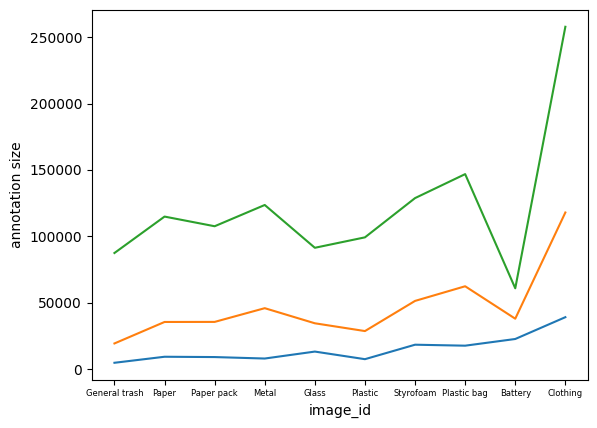

In [151]:
x_1 = annotations.groupby('category_id')['area'].quantile(0.25).index
y_1 = annotations.groupby('category_id')['area'].quantile(0.25).values

x_2 = annotations.groupby('category_id')['area'].quantile(0.5).index
y_2 = annotations.groupby('category_id')['area'].quantile(0.5).values

x_3 = annotations.groupby('category_id')['area'].quantile(0.75).index
y_3 = annotations.groupby('category_id')['area'].quantile(0.75).values

print("<annotation size>")
print("max : ", max(ann_size))
print("min : ", min(ann_size))

plt.plot(x_1, y_1)
plt.plot(x_2, y_2)
plt.plot(x_3, y_3)
plt.xlabel("image_id")
plt.xticks(np.arange(0,10), label_list, size=6)
plt.ylabel("annotation size")
plt.show()

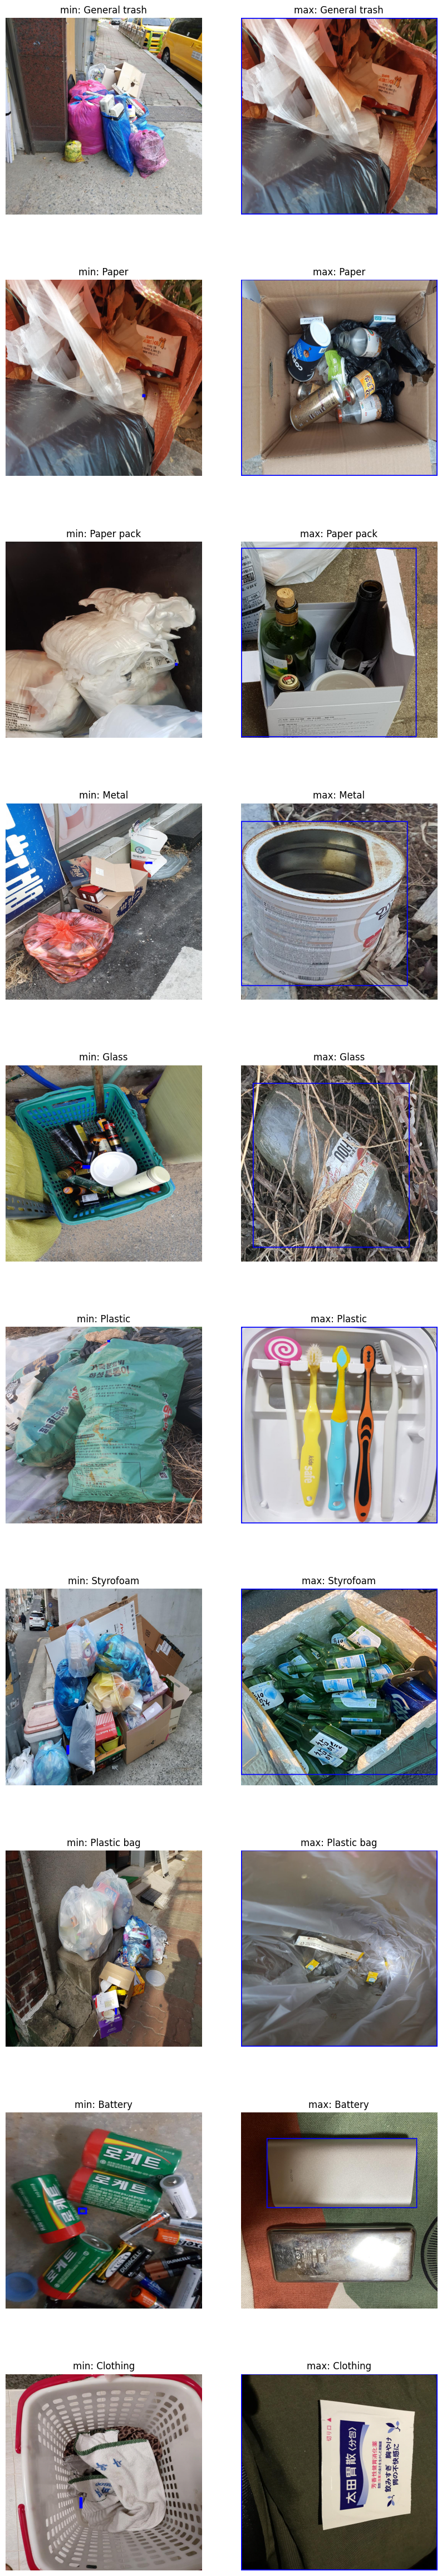

In [161]:
# 카테고리 별 이미지 확인

plt.figure(figsize=(10,60))
plt.tight_layout()
for i, cat in enumerate(range(10)):
    annot = annotations[annotations["category_id"] == cat]

    min_idx = annot['area'].idxmin()
    min_img = annot.loc[annot['area'].idxmin(), 'image_id']
    img_path = f"../dataset/train/{str(min_img).zfill(4)}.jpg"
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    box = annot.loc[annot['area'].idxmin(), 'bbox']
    draw.rectangle((box[0], box[1], box[0] + box[2], box[1] + box[3]), outline = 'Blue', width=10)
    
    plt.subplot(10, 2, i * 2 + 0 + 1)
    plt.title('min: ' + label_list[cat])
    plt.axis("off")
    plt.imshow(img)
    

    max_idx = annot['area'].idxmax()
    max_img = annot.loc[annot['area'].idxmax(), 'image_id']
    img_path = f"../dataset/train/{str(max_img).zfill(4)}.jpg"
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    box = annot.loc[annot['area'].idxmax(), 'bbox']
    draw.rectangle((box[0], box[1], box[0] + box[2], box[1] + box[3]), outline = 'Blue', width=5)

    plt.subplot(10, 2, i * 2 + 1 + 1)
    plt.title('max: ' + label_list[cat])
    plt.axis("off")
    plt.imshow(img)

* 너무 작은 annotation: 오분류, 사람 육안으로도 확인 불가능  
-> 삭제하는 게 성능 향상에 좋을 것 같음
* 너무 큰 annotation: 사진 전체를 태그한 경우
* 포장지 쓰레기: Paper, Paperpack, Plastic bag
-> 이미지 전체가 bbox인 경우가 많아 보임.